# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4oq1trzf
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4oq1trzf
  Resolved https://github.com/albumentations-team/albumentations to commit b773a1aa69f9c823c7f593205614d05d32c039cb
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


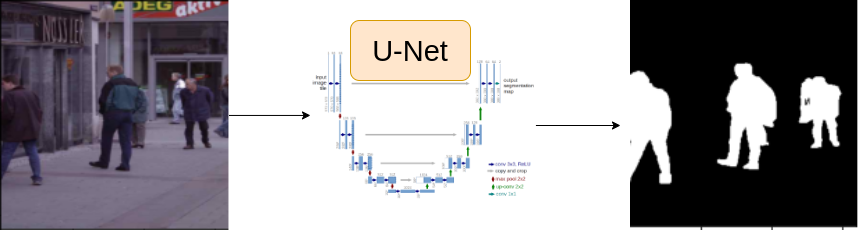

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]
image_path = row.images 
mask_path = row.masks 

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

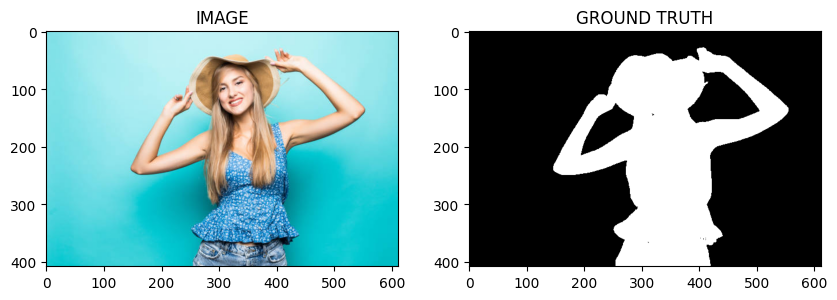

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df) 

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images 
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w)
    mask = np.expand_dims(mask, axis = -1) #(h, w, c)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h,w,c) -> (c,h,w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320])
torch.Size([1, 320, 320])


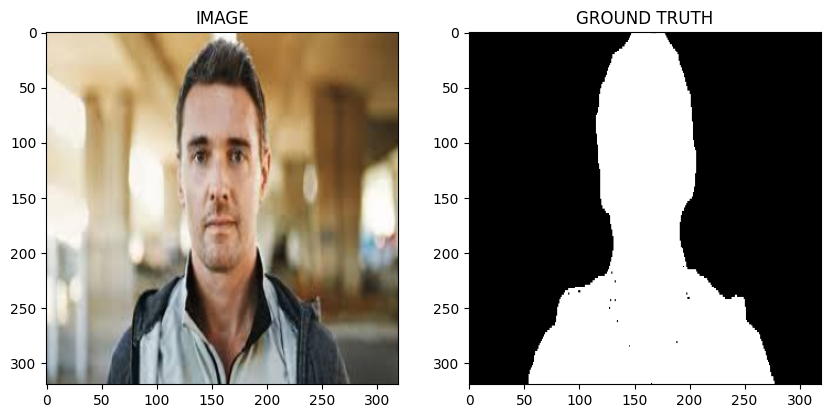

In [16]:
idx = 32
image, mask = trainset[idx]
helper.show_image(image, mask)
print(image.shape)
print(mask.shape)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [20]:
for image, mask in trainloader:
  break

print(f"one batch image shape : {image.shape}")
print(f"one batch mask shape : {mask.shape}")

one batch image shape : torch.Size([16, 3, 320, 320])
one batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [24]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(data_loader)

In [25]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      
    
      total_loss += loss.item()
  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [28]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.4023409167925517 Valid_loss : 0.41975385695695877


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.35105601052443186 Valid_loss : 0.266893457621336


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


SAVED-MODEL
Epoch : 3 Train_loss : 0.24484332799911498 Valid_loss : 0.2656526565551758


100%|██████████| 4/4 [00:00<00:00,  5.39it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.22287237147490183 Valid_loss : 0.23872772976756096


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Epoch : 5 Train_loss : 0.21611652473608653 Valid_loss : 0.2440074421465397


100%|██████████| 4/4 [00:01<00:00,  3.58it/s]


Epoch : 6 Train_loss : 0.20943283240000407 Valid_loss : 0.25710301101207733


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


SAVED-MODEL
Epoch : 7 Train_loss : 0.18595373729864756 Valid_loss : 0.2183271273970604


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


SAVED-MODEL
Epoch : 8 Train_loss : 0.17576450357834497 Valid_loss : 0.1995440386235714


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAVED-MODEL
Epoch : 9 Train_loss : 0.1814031794667244 Valid_loss : 0.19360646978020668


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch : 10 Train_loss : 0.14563757528861362 Valid_loss : 0.1978716477751732


100%|██████████| 4/4 [00:00<00:00,  5.32it/s]


SAVED-MODEL
Epoch : 11 Train_loss : 0.15312956968943278 Valid_loss : 0.1789113450795412


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


Epoch : 12 Train_loss : 0.15933614770571392 Valid_loss : 0.23851865530014038


100%|██████████| 4/4 [00:00<00:00,  4.37it/s]


SAVED-MODEL
Epoch : 13 Train_loss : 0.13772391825914382 Valid_loss : 0.17133866995573044


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


Epoch : 14 Train_loss : 0.12695344239473344 Valid_loss : 0.20548612624406815


100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Epoch : 15 Train_loss : 0.1325840373833974 Valid_loss : 0.2949739284813404


100%|██████████| 4/4 [00:00<00:00,  4.13it/s]


Epoch : 16 Train_loss : 0.14175516068935395 Valid_loss : 0.25524814426898956


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]


Epoch : 17 Train_loss : 0.13376583655675253 Valid_loss : 0.18747596815228462


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch : 18 Train_loss : 0.11147972345352172 Valid_loss : 0.21494515985250473


100%|██████████| 4/4 [00:01<00:00,  3.36it/s]


Epoch : 19 Train_loss : 0.10621082385381063 Valid_loss : 0.1849813126027584


100%|██████████| 4/4 [00:00<00:00,  4.38it/s]


SAVED-MODEL
Epoch : 20 Train_loss : 0.09706173886855443 Valid_loss : 0.14677852764725685


100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


Epoch : 21 Train_loss : 0.10764181564251582 Valid_loss : 0.21935011073946953


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch : 22 Train_loss : 0.10238504161437352 Valid_loss : 0.25398803874850273


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


Epoch : 23 Train_loss : 0.11812364707390467 Valid_loss : 0.22451039776206017


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch : 24 Train_loss : 0.13475343585014343 Valid_loss : 0.19226595759391785


100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

Epoch : 25 Train_loss : 0.11593506435553233 Valid_loss : 0.24244292825460434


# Task 9 : Inference

In [31]:
idx = 30

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) *1.0

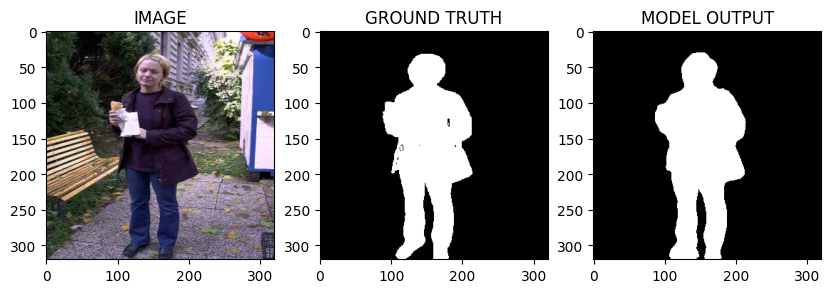

In [32]:
helper.show_image(image,mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya